# Exploratary data analysis - Tennis Match between Djokovic and Federer
![Title](tennisCourt.jpg)

### Reading csv

We'll start off by importing necessary packages and reading the dataset

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import figure

In [2]:
df = pd.read_csv('03_tennisai_data.csv')



Next, of course, we are interested to see if Nole won

First, we'll check out the **player labels**

In [3]:
df[['p1','p2']].head(1)

,p1,p2
0,djokovic,federer


Now, let's see the end of the matchpoint column (remember, Nole == 1, Federer == 2)

In [4]:
df['matchpoint'].tail(1)

421    1
Name: matchpoint, dtype: int64

Cheers, **Nole won**. Now, let's see how much matchpoints did each player have

In [5]:
df['matchpoint'].value_counts()

0    419
2      2
1      1
Name: matchpoint, dtype: int64

Hm, at first, it seems that Federer had two matchpoints. But, we can't be certain, it could just be the same ongoing point. Let's see the indexes of these matchpoints.

In [6]:
np.nonzero(df['matchpoint'].to_numpy())

(array([358, 359, 421]),)

As you can see, Federer's matchpoints were in fact consecutive timeframes. The problem is that we can't know for certain if it is the same point ;( 

We have to find the way to save the dataframe based on distinct points (not just for matchpoints, there are setpoints and breakpoints too, we can't check them all manually)

### Groupby

This is very a SQL-like way to do things, but in this case, it saves us a lot of pointless coding

In [7]:
dfSub = df[['p1_sets','p1_games','p1_points','p2_sets','p2_games','p2_points','matchpoint']]

In [8]:
dfGroup = dfSub.groupby(['p1_sets','p1_games','p1_points','p2_sets','p2_games','p2_points']).max()
dfGroup

matchpoint
p1_sets p1_games p1_points p2_sets p2_games p2_points            
0       0        0         0       0        0                   0
                                            15                  0
                                            30                  0
                                   1        0                   0
                 15        0       0        30                  0
...                                                           ...
2       12       4         2       12       1                   0
                                            2                   0
                                            3                   0
                 5         2       12       3                   0
                 6         2       12       3                   1

[409 rows x 1 columns]

In [9]:
dfgrp = dfSub.groupby(['p1_sets','p1_games','p1_points','p2_sets','p2_games','p2_points']).max()
dfgrp['matchpoint'].value_counts()

0    406
2      2
1      1
Name: matchpoint, dtype: int64

Now we see that those really are distinct points and that Federer actually had two matchpoints

Let's do the same for breakpoints and setpoints (we'll actually add the matchpoints too, so that they're all together) and illustrate it

In [10]:
dfSub = df[['p1_sets','p1_games','p1_points','p2_sets','p2_games','p2_points','matchpoint','setpoint','breakpoint']]
dfgrp = dfSub.groupby(['p1_sets','p1_games','p1_points','p2_sets','p2_games','p2_points']).max()
dfgrp['setpoint'].value_counts(),dfgrp['breakpoint'].value_counts(),dfgrp['matchpoint'].value_counts()


(0    401
 2      5
 1      3
 Name: setpoint, dtype: int64,
 0    389
 2     12
 1      8
 Name: breakpoint, dtype: int64,
 0    406
 2      2
 1      1
 Name: matchpoint, dtype: int64)

Plotting...

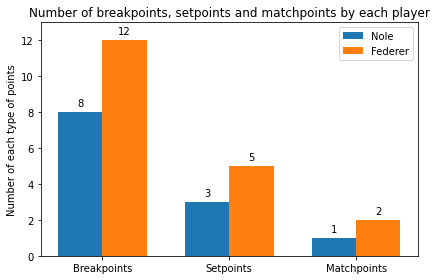

In [11]:
labels = ['Breakpoints', 'Setpoints', 'Matchpoints']
nole_values = [dfgrp['breakpoint'].value_counts()[1],dfgrp['setpoint'].value_counts()[1],dfgrp['matchpoint'].value_counts()[1]]
federer_values = [dfgrp['breakpoint'].value_counts()[2],dfgrp['setpoint'].value_counts()[2],dfgrp['matchpoint'].value_counts()[2]]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, nole_values, width, label='Nole')
rects2 = ax.bar(x + width/2, federer_values, width, label='Federer')


ax.set_ylabel('Number of each type of points')
ax.set_title('Number of breakpoints, setpoints and matchpoints by each player')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=4)
ax.bar_label(rects2, padding=4)
ax.set_ybound(0,13)
fig.tight_layout()



As you can see, Federer has Nole beat in every single category. Seems like statistics is not everything ;)

Next, we'll focus on the point duration (measured in # of ball hits). Let's see who likes the long exchanges.

### Binning

We will divide point duration in three categories - short, average and long points 

This way, it's much less complex to look at

In [12]:
grpDf = df.groupby(['p1_sets','p1_games','p1_points','p2_sets','p2_games','p2_points']).max()
bins = np.linspace(min(grpDf["detected_ballhit_count"]), max(grpDf["detected_ballhit_count"]), 4)
binLabels = ['Short point', 'Average point', 'Long point']
grpDf['pointDuration-binned'] = pd.cut(grpDf['detected_ballhit_count'], bins, labels=binLabels, include_lowest=True )

In [13]:
grpDf['pointDuration-binned'].value_counts()

Short point      355
Average point     48
Long point         6
Name: pointDuration-binned, dtype: int64

As you can see, there aren't that many long points (in fact, short points are dominant, which makes sense)

Let's see who rules over these categories

In [14]:
temp1 = grpDf['pointDuration-binned'].to_numpy()

In [15]:
longPoint = np.where(temp1 == 'Long point', True, False)
shortPoint = np.where(temp1 == 'Short point', True, False)
avgPoint = np.where(temp1 == 'Average point', True, False)

temp2 = grpDf['pt_won_by'].to_numpy()
nolePoint = np.where(temp2 == 1, True, False)
fedPoint =  np.where(temp2 == 2, True, False)

noleShort = np.logical_and(nolePoint, shortPoint)
nslen = len([x for x in noleShort if x == True])

fedShort = np.logical_and(fedPoint, shortPoint)
fslen = len([x for x in fedShort if x == True])

noleAvg = np.logical_and(nolePoint, avgPoint)
nalen = len([x for x in noleAvg if x == True])

fedAvg = np.logical_and(fedPoint, avgPoint)
falen = len([x for x in fedAvg if x == True])

noleLong = np.logical_and(nolePoint, longPoint)
nllen = len([x for x in noleLong if x == True])

fedLong = np.logical_and(fedPoint, longPoint)
fllen = len([x for x in fedLong if x == True])


Now, it's the best part - **plotting time!**

(0.0, 200.0)

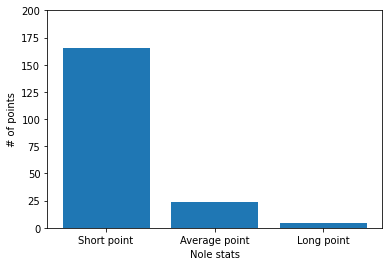

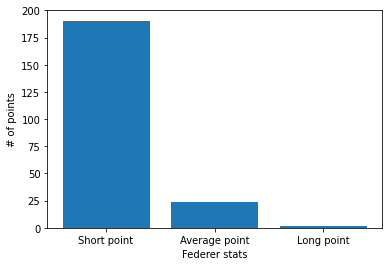

In [16]:
plot1 = plt.figure(1)
plt.bar(binLabels, [nslen, nalen, nllen])
plt.xlabel('Nole stats')
plt.ylabel('# of points')
plt.ylim([0, 200])
plot2 = plt.figure(2)
plt.bar(binLabels, [fslen, falen, fllen])
plt.xlabel('Federer stats')
plt.ylabel('# of points')
plt.ylim([0, 200])

#### Result analysis

This category is slightly taken by Federer. He has taken arround 20 more short points than Novak. Though, difference isn't that big, considering it's about a 10 percent lead. Interestingly, they have won the same number of average points, while Nole has twice as many long points. 

### Some hit statistics

Now, since this isn't your average tennis match statistics, we'll analyse things a little different. Let's analyse what are the odds for different hits to succeed/fail.

In [24]:
noleServe, fedServe = grpDf[['server']].value_counts()

temp, noleAce, fedAce = grpDf[['ace']].value_counts()
temp, noleDbl, fedDbl = grpDf[['double_fault']].value_counts()

In [25]:
noleDbl, fedDbl

(9, 6)

In [31]:
labelsPie = ['Aces', 'Double faults', 'Other']
sizesNole = [noleAce / noleServe, noleDbl / noleServe, 1 - (noleAce + noleDbl)/noleServe]
sizesNole = [round(x,2) for x in sizesNole]

sizesFed = [fedAce / fedServe, fedDbl / fedServe, 1 - (fedAce + fedDbl)/ fedServe]
sizesFed = [round(x,2) for x in sizesFed]

**Serve statistics:**

Text(0.5, 0.98, 'Nole serve')

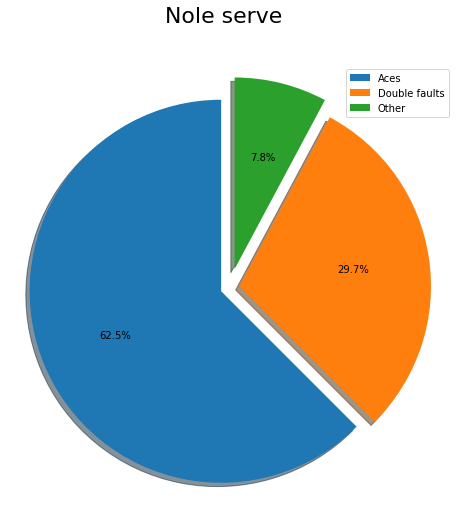

In [81]:
explode = [0.05, 0.05, 0.1]
fig, ax = plt.subplots(1,1,figsize = (8,8))
ax.pie(sizesNole,explode = explode, shadow = True,autopct='%1.1f%%', startangle=90 )
ax.axis('equal')
ax.legend(labels = labelsPie)
fig.suptitle('Nole serve', fontsize = 22)

Text(0.5, 0.98, 'Federer Serve')

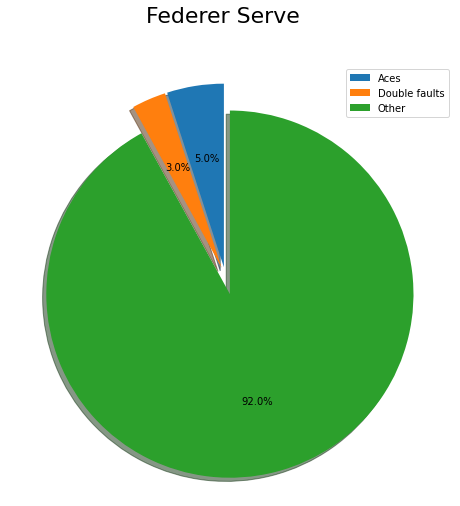

In [80]:
#plotting pie chart
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
ax.pie(sizesFed,explode = explode,shadow = True, autopct='%1.1f%%', startangle=90 )
ax.axis('equal')
ax.legend(labels = labelsPie)
#ax.title.set_text('Federer serve', fontsize = 16)
fig.suptitle('Federer Serve', fontsize = 22)

In [46]:
temp, noleWinner, fedWinner = df['winner'].value_counts()

In [50]:
temp, noleFhwin, fedFhwin = df['forehand_winner'].value_counts()
temp, noleBkwin, fedBkwin = df['backhand_winner'].value_counts()

Text(0.5, 0.98, 'Nole winners')

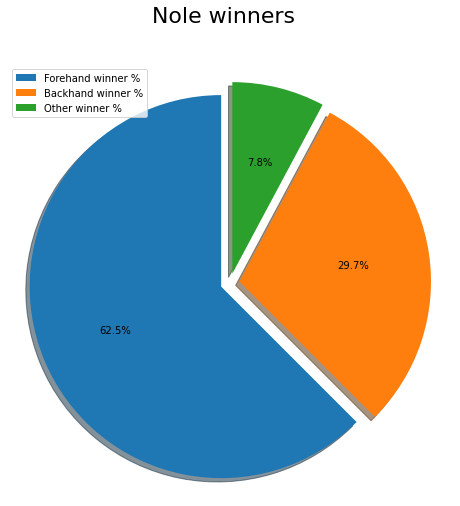

In [83]:
#plotting pie chart, again...
labelsPieWinner = ['Forehand winner %', 'Backhand winner %', 'Other winner %']
sizesNole = [noleFhwin / noleWinner, noleBkwin / noleWinner, 1 - (noleFhwin + noleBkwin) / noleWinner]
explode = [0.05, 0.05, 0.05]
fig,ax = plt.subplots(1,1,figsize = (8,8))
ax.pie(sizesNole,autopct='%1.1f%%',explode = explode, shadow = True, startangle=90 )
ax.axis('equal')
ax.legend(labels = labelsPieWinner)
fig.suptitle('Nole winners', fontsize = 22)

Text(0.5, 0.98, 'Fed winners')

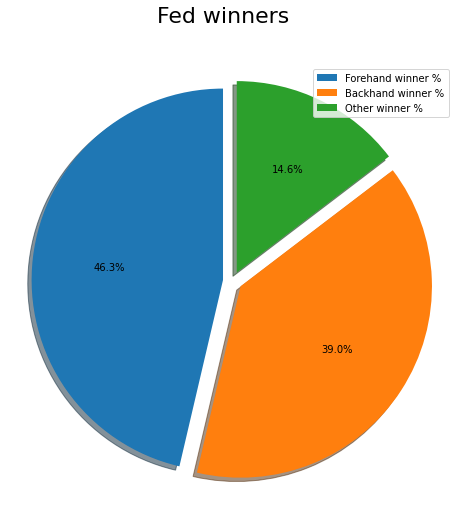

In [85]:
sizesFed = [fedFhwin / fedWinner,fedBkwin / fedWinner, 1 - (fedFhwin + fedBkwin) / fedWinner]
explode = [0.05, 0.05, 0.05]
fig,ax = plt.subplots(1,1,figsize = (8,8))
ax.pie(sizesFed,autopct='%1.1f%%',explode = explode, shadow = True, startangle=90 )
ax.axis('equal')
ax.legend(labels = labelsPieWinner)
fig.suptitle('Fed winners', fontsize = 22)

Seems like Nole is relying on his forehand a lot, since more than half of his winners are won by forehand. On the other side, Federer is pretty balanced in this regard

### Point duration over time

Let's see how does the point duration change in time. One can argue that while match drags on, the players played more reserved and the points take longer. Let's check out if it's true.

Text(0.5, 0.98, 'Correlation between match duration and point duration')

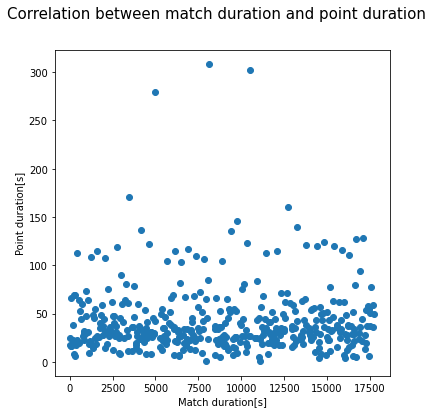

In [95]:
fig, ax = plt.subplots(1,1, figsize = (6,6))
xaxis = df['vid_second']
yaxis = df['point_duration']
ax.scatter(xaxis,yaxis)
ax.set_xlabel('Match duration[s]')
ax.set_ylabel('Point duration[s]')
fig.suptitle('Correlation between match duration and point duration', fontsize = 15)

Well, seems like there isn't too much correlation between these two. Oh well, it was worth trying. But this gave me another idea - does the same point duration always result in same (very close) number of hits? If this holds true, it means that relation should be linear. Time to check that!

Text(0.5, 0.98, 'Correlation between and point duration')

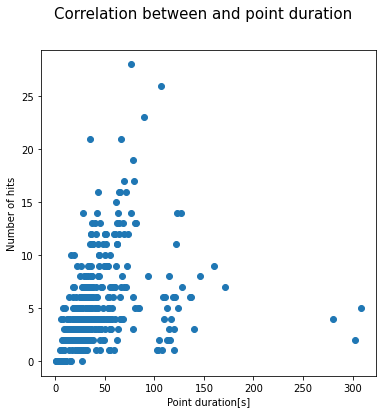

In [96]:
fig, ax = plt.subplots(1,1, figsize = (6,6))
xaxis = df['point_duration']
yaxis = df['detected_ballhit_count']
ax.scatter(xaxis,yaxis)
ax.set_xlabel('Point duration[s]')
ax.set_ylabel('Number of hits')
fig.suptitle('Correlation between and point duration', fontsize = 15)

Now this is interesting! We have a practically linear relationship in the left part of the graph, but we have some moderate exceptions and a few serious exceptions. Those serious ones should be considered as a data gathering mistake, it seems unreal that 5 hits would last for 300 seconds. First, let's get rid of them in this analysis:

In [116]:
pointDur = df['point_duration'].to_numpy()
hits = df['detected_ballhit_count'].to_numpy()
pointDur = pointDur[np.nonzero(hits)]
hits = hits[np.nonzero(hits)]
k = pointDur / hits

Let's say that the absolute most time between two hits is 10 seconds. That means that we'll get rid of points whose duration per hits ratio is over 10

In [119]:
validIndexes = []
for i in range(len(hits)):
    if k[i] < 10:
        validIndexes.append(i)
        
        
pointDur = pointDur[validIndexes]
hits = hits[validIndexes]

Text(0.5, 0.98, 'Correlation between and point duration')

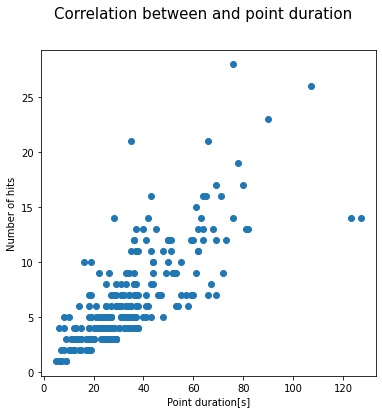

In [121]:
#now, let's scatter!
fig, ax = plt.subplots(1,1, figsize = (6,6))
xaxis = pointDur
yaxis = hits
ax.scatter(xaxis,yaxis)
ax.set_xlabel('Point duration[s]')
ax.set_ylabel('Number of hits')
fig.suptitle('Correlation between and point duration', fontsize = 15)

This relationship seems very linear to me. Let's **fit a line!**

Text(0.5, 0.98, 'Correlation between and point duration')

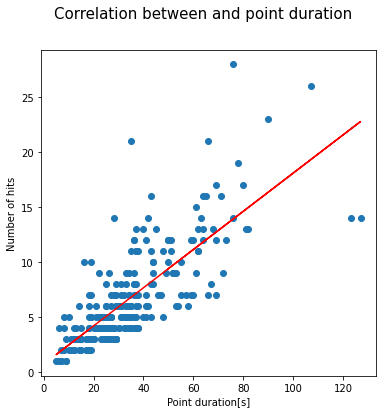

In [124]:
m, b = np.polyfit(xaxis, yaxis, 1)
yline = m * xaxis + b
fig, ax = plt.subplots(1,1, figsize = (6,6))
xaxis = pointDur
yaxis = hits
ax.scatter(xaxis,yaxis)
ax.plot(xaxis, yline, 'r', label = 'y = ')
ax.set_xlabel('Point duration[s]')
ax.set_ylabel('Number of hits')
fig.suptitle('Correlation between and point duration', fontsize = 15)

In [125]:
m

0.17394437849754096


So, on average, we have 0.17 hits a second, a.k.a. one **hit every 5-6 seconds.**